In [ ]:
# -----------------------------------------------------------------------------------------------------
# Inception V3 model to build shared CNN layer
# Original: .py file [Here is just a presentation]
# Reference:
#    [Rethinking the Inception Architecture for Computer Vision](http://arxiv.org/abs/1512.00567)
#    & inception_v3 in keras
# Note: 
#    We are still work on this net and we want to find the optimal structure
#    This structure is may not the optimal one, even a good one
#    and testing it is time consuming.
# ------------------------------------------------------------------------------------------------------

### Import Library

In [2]:
from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras import backend as K
import json
import warnings
import numpy as np

Using TensorFlow backend.


In [3]:
###### inception v3 has a good property compared with v4: it has pretrained weight #######

In [ ]:
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
###### From Reference ######

In [4]:
def _preprocess_numpy_input(x, data_format, mode):
    if mode == 'tf':
        x /= 127.5
        x -= 1.
        return x

    if data_format == 'channels_first':
        if x.ndim == 3:
            # 'RGB'->'BGR'
            x = x[::-1, ...]
            # Zero-center by mean pixel
            x[0, :, :] -= 103.939
            x[1, :, :] -= 116.779
            x[2, :, :] -= 123.68
        else:
            x = x[:, ::-1, ...]
            x[:, 0, :, :] -= 103.939
            x[:, 1, :, :] -= 116.779
            x[:, 2, :, :] -= 123.68
    else:
        # 'RGB'->'BGR'
        x = x[..., ::-1]
        # Zero-center by mean pixel
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
    return x


def _preprocess_symbolic_input(x, data_format, mode):
    global _IMAGENET_MEAN

    if mode == 'tf':
        x /= 127.5
        x -= 1.
        return x

    if data_format == 'channels_first':
        # 'RGB'->'BGR'
        if K.ndim(x) == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'RGB'->'BGR'
        x = x[..., ::-1]

    if _IMAGENET_MEAN is None:
        _IMAGENET_MEAN = K.constant(-np.array([103.939, 116.779, 123.68]))
    # Zero-center by mean pixel
    if K.dtype(x) != K.dtype(_IMAGENET_MEAN):
        x = K.bias_add(x, K.cast(_IMAGENET_MEAN, K.dtype(x)), data_format)
    else:
        x = K.bias_add(x, _IMAGENET_MEAN, data_format)
    return x


def preprocess_input(x, data_format=None, mode='caffe'):
    """Preprocesses a tensor encoding a batch of images.
    # Arguments
        x: input Numpy or symoblic tensor, 3D or 4D.
        data_format: data format of the image tensor.
        mode: One of "caffe", "tf".
            - caffe: will convert the images from RGB to BGR,
                then will zero-center each color channel with
                respect to the ImageNet dataset,
                without scaling.
            - tf: will scale pixels between -1 and 1,
                sample-wise.
    # Returns
        Preprocessed tensor.
    """
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format ' + str(data_format))

    if isinstance(x, np.ndarray):
        return _preprocess_numpy_input(x, data_format=data_format, mode=mode)
    else:
        return _preprocess_symbolic_input(x, data_format=data_format,
                                          mode=mode)
def decode_predictions(preds, top=5):
    """Decodes the prediction of an ImageNet model.
    # Arguments
        preds: Numpy tensor encoding a batch of predictions.
        top: integer, how many top-guesses to return.
    # Returns
        A list of lists of top class prediction tuples
        `(class_name, class_description, score)`.
        One list of tuples per sample in batch input.
    # Raises
        ValueError: in case of invalid shape of the `pred` array
            (must be 2D).
    """
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models',
                         file_hash='c2c37ea517e94d9795004a39431a14cb')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate an ImageNet model's input shape.
    # Arguments
        input_shape: either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: default input width/height for the model.
        min_size: minimum input width/height accepted by the model.
        data_format: image data format to use.
        require_flatten: whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: one of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: in case of invalid argument values.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting`include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                   (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                   (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape


def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    """Utility function to apply conv + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x

In [5]:
###### Reference Part stops here ######

### Shared CNN: Inception V3

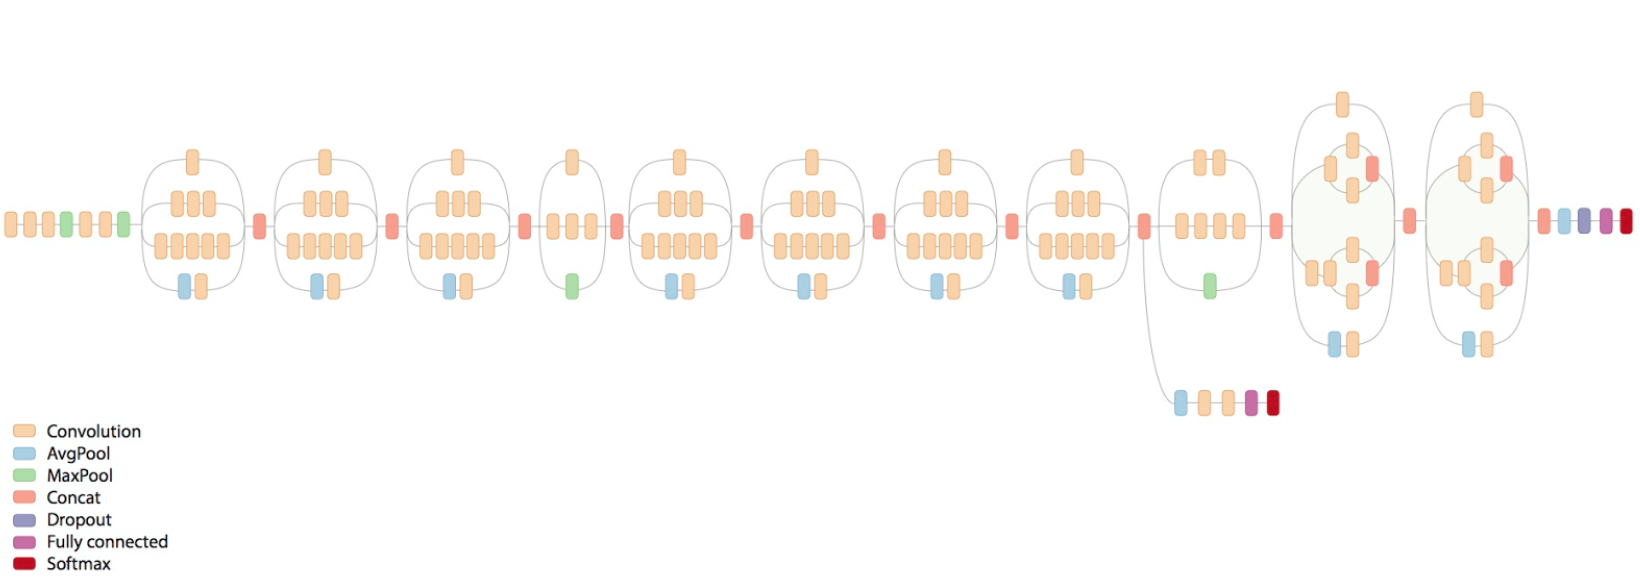

In [6]:
####### Visulization ########
from PIL import Image
Image.open('/Users/zehaodong/Desktop/AML_Final/keras-frcnn-master/inception_v3.png')

In [7]:
def nn_base(input,trainable=False,include_top=False,pooling='avg'):
    """
    In first 3 Mixture Blocks, I reduce conv layer following this rule:
    (1) 3 continuous --> 2
    (2) 5 continous --> 3
    (3) keep the shape of last layer
    Reason:
    reduce the complexity of this shared CNN, reduce computational complexity
    """
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    ###### Premixing layers ######
    x = conv2d_bn(input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    ##### Mixture Block 1 ##### 
    # shape: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    ###### mixture Block 2 ##### 
    # shape: 35 x 35 x 256 
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    ###### mixture Block3 ###### 
    #shape:35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    ###### mixture Block 4 ##### 
    #shape:17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn( branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed3')

    ###### mixture Block 5 ##### 
    #shape:17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    ##### Mixture Block 6 ##### 
    # shape: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    ##### Mixture Block 7 ##### 
    #shape: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    ##### Mixture Block 8##### 
    #shape: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch7x7x3, branch_pool], axis=channel_axis, name='mixed8')

    ###### mixed 9 ##### 
    #shape: 8 x 8 x 2048
    # --------------------------------------------------------------------------
    # NOTE: I choose to stop here, for we have fully maked use of this structure
    #       and after that might cause error
    #       NOT SURE it is a good idea, need to test
    # --------------------------------------------------------------------------
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2], axis=channel_axis, name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis)

    return x

### Stucture Functions

In [ ]:
"""
Funtions to build faster rcnn model in the training process 
and rebuild corresponding faster rcnn model in the test process
"""

In [8]:
import warnings
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras_frcnn.RoiPoolingConv import RoiPoolingConv
from keras.layers import Input, Add, Dense, Activation, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, \
    AveragePooling2D, TimeDistributed
from keras import backend as K
from keras_frcnn.FixedBatchNormalization import FixedBatchNormalization

In [9]:
def rpn(base_layers, num_anchors):
    """
    Used for testing
    inputs:
        base_layers: feature map, output from shared CNN (raw feature extraction net)
        num_anchors: in faster rcnn, equals to 3 x 3
    output: 
        x_cls: 9-d, used to build cls_loss, cross entropy
        x_regr: 4x9-d, used to build regr_loss, smooth L1
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    x_cls = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
    return [x_cls, x_regr, base_layers]

In [10]:
def classifier(base_layers, input_rois, num_rois, nb_classes = 21, trainable=False):
    """
    Used in training process and test process
    Inputs:
        base_layers: feature map, output from shared CNN (raw feature extraction net)
        input_rois: roipooling layer
        num_rois: number of rois
    Outputs:
        out_cls: inputs for cross entropy loss
        out_regr: inputs for smooth L1 loss
    """
    # backend checking
    if K.backend() == 'tensorflow':
        pooling_regions = 8
        input_shape = (num_rois,8,8,2048)
    elif K.backend() == 'theano':
        pooling_regions = 7
        input_shape = (num_rois,2048,8,8)

    ##### Roipooling layer #####
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    ##### feature map generation layer #####
    out = classifier_layers(out_roi_pool, input_shape=input_shape, trainable=True)
    out = TimeDistributed(Flatten())(out)

    ##### output layers #####
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)
    return [out_class, out_regr]

In [11]:
def get_weight_path():
    if K.image_dim_ordering() == 'th':
        return 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    else:
        return 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5'

In [12]:
def get_img_output_length(width, height):
    """
    SAME AS Inception_v3
    WHY: get_output_length like below
    based on the resnet:  strides = (2,2), padding='valid': 
                          then output_length = (input_length - filter_size + stride) // stride + 1 
    """
    def get_output_length(input_length):
        l1 = (input_length-3)//2+1
        l2 = (l1-3)+1
        l3 = (l2-3)//2+1
        l4 = (l3-3)+1
        l5= (l4-3)//2+1
        l6= (l5-3)//2+1
        return l6
    return get_output_length(width), get_output_length(height) 